### 1.Installing the Relevant Packages

In [1]:
# Required packages
import scanpy as sc 
from scimilarity.cell_embedding import CellEmbedding
from scimilarity.utils import align_dataset, lognorm_counts


import torch
torch.manual_seed(1606) 
import numpy as np
np.random.seed(1606)    
import random
random.seed(1606)       
import time
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from analyses_utils import embedding_plots, loss_function_plot, measure_random_forest_performance, train_one_epoch

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

C:\Users\gecic\anaconda3\envs\Env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.Preparation Procedures

In [2]:
# Preprocessing and Label Encoding of TCGA Single-Cell Gene Expression Data
ce = CellEmbedding(model_path = r"\Users\gecic\PhDThesis\scimilarity\model_v1.1")

# load TCGA data
data_path = r"\Users\gecic\PhDThesis/scimilarity/TCGA_mrna_tpm_unstranded.h5ad"
TCGA = sc.read_h5ad(data_path)
TCGA = align_dataset(TCGA, ce.gene_order)
TCGA = lognorm_counts(TCGA)

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output = False)
y = label_encoder.fit_transform(TCGA.obs.cohort)
Y = one_hot_encoder.fit_transform(y[:, None])

In [3]:
# Dataset Creation
# First split of the dataset into train and test datasets. 
# We have over 10.000 patients. We split %80-%20 as train and test
X_train_step4, X_test_step4, Y_train_step4, Y_test_step4 = train_test_split(TCGA.X, Y,
                                                       test_size = 0.2, random_state = 1234,
                                                       shuffle = True, stratify = TCGA.obs.cohort)

In [4]:
# PyTorch TensorDataset ve DataLoader Yapılarının Oluşturulması
# The TCGA dataset, after undergoing preprocessing steps, is converted into a suitable format for use in deep learning models using PyTorch.
TCGA_train = torch.utils.data.TensorDataset(torch.tensor(X_train_step4.toarray()).to(torch.float32), torch.tensor(Y_train_step4).to(torch.float32))
TCGA_test = torch.utils.data.TensorDataset(torch.tensor(X_test_step4.toarray()).to(torch.float32), torch.tensor(Y_test_step4).to(torch.float32))

train_loader = torch.utils.data.DataLoader(TCGA_train, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(TCGA_test, batch_size = 64, shuffle = False)

### 3.Model Architecture

In [5]:
# Deep Learning Model Architecture and Definition
encoder_model = torch.nn.Sequential()
for module in ce.model.get_submodule("network").modules():
  if (type(module).__name__ != "ModuleList") and (type(module).__name__ != "Sequential"):
    encoder_model.append(module)
#print(encoder_model)

classifier_model = torch.nn.Sequential()
classifier_model.append(torch.nn.Linear(in_features = 128, out_features = 64))
classifier_model.append(torch.nn.ReLU())
classifier_model.append(torch.nn.Linear(in_features = 64, out_features = 33))
classifier_model.append(torch.nn.Softmax(dim = 1))
#print(classifier_model)

class ClassifierAfterEncoder(torch.nn.Module):
    def __init__(self, encoder, classifier):
        super(ClassifierAfterEncoder, self).__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        x = self.encoder(x)
        x = torch.nn.functional.normalize(x, p = 2, dim = 1)
        x = self.classifier(x)
        return x

model = ClassifierAfterEncoder(encoder_model, classifier_model)

model.compile()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001)

In [6]:
# Epoch-Based Training Loss Curve
start_train = time.time()
train_losses = []
model.train()
for i in range(250): # Train over 250 epochs
    # The training size can be adjusted by changing the number of epochs within the for loop. 
    #For the analyses, 250, 500, 750, and 1000 were used as epoch values.
    loss = train_one_epoch(model,
                           train_loader,
                           optimizer,
                           loss_fn
    )
    train_losses.append(loss)
    #print(i, loss)
end_train = time.time()
print(f"Training time: {end_train - start_train:.2f} seconds")

Training time: 6412.41 seconds


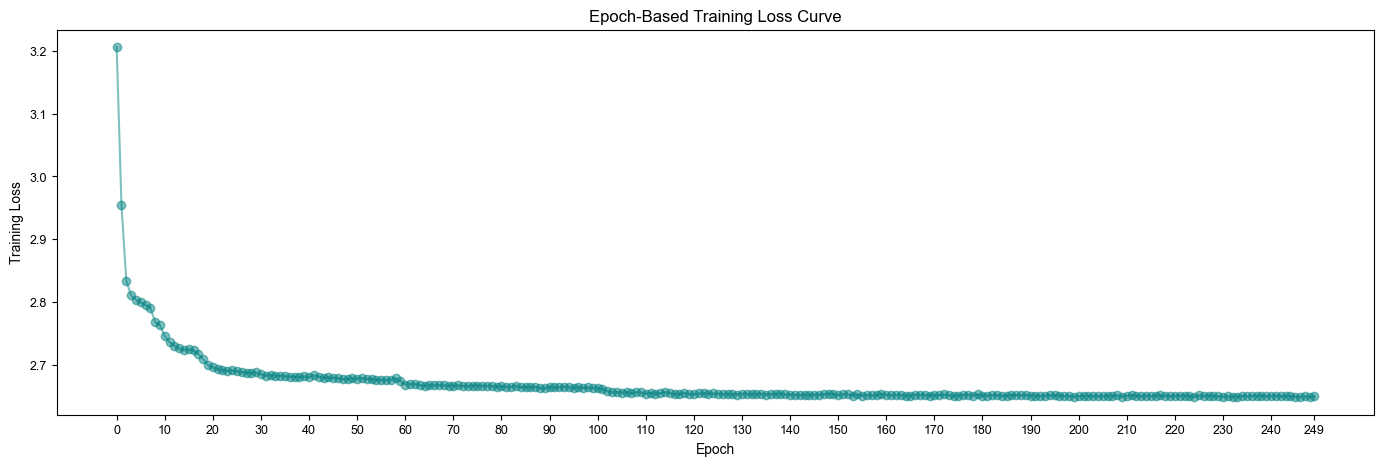

In [7]:
loss_function_plot(train_losses, step=10, figsize=(17, 5))

### 4.Cell Embeddings

In [8]:
# Model Evaluation and Obtaining Cell Embeddings
model.eval()
y_train_hat = model(torch.tensor(X_train_step4.toarray()).to(torch.float32))
y_test_hat = model(torch.tensor(X_test_step4.toarray()).to(torch.float32))

y_train_hat = np.argmax(y_train_hat.cpu().detach().numpy(), axis = 1)
y_test_hat = np.argmax(y_test_hat.cpu().detach().numpy(), axis = 1)

print("Train Accuracy",round(np.mean(y_train_hat == np.argmax(Y_train_step4, axis = 1)),3))
print("Test Accuracy", round(np.mean(y_test_hat == np.argmax(Y_test_step4, axis = 1)),3))

embedding_hat = encoder_model(torch.tensor(TCGA.X.toarray()).to(torch.float32))
TCGA.obsm["X_all-layers_250_RMSprop_001"] = embedding_hat.cpu().detach().numpy()

Train Accuracy 0.902
Test Accuracy 0.881


In [9]:
# Recording Embedding Results 
np.savetxt(fname = "All-layers_Fine-tuning_250_RMSprop_001.csv", 
           X = TCGA.obsm["X_all-layers_250_RMSprop_001"], delimiter = ",")

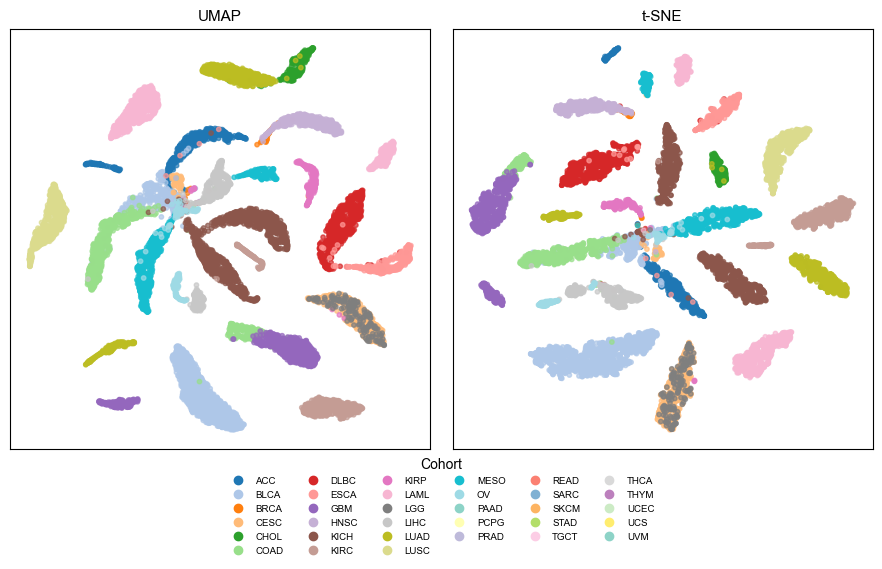

In [11]:
embedding_plots(
    data = TCGA.obsm["X_all-layers_250_RMSprop_001"], 
    classes = TCGA.obs["cohort"]
)

### 5.Multiclass Classification

In [12]:
# Multiclass Classification of Embedding Results Using Random Forest Algorithm
# Measure the predictive performance using embeddings obtained from the trained model
start_rf = time.time()
# measure the predictive performance using embeddings obtained from trained model
measure_random_forest_performance(TCGA.obsm["X_all-layers_250_RMSprop_001"], TCGA.obs.cohort)
end_rf = time.time()
print(f"Random Forest training time: {end_rf - start_rf:.2f} seconds")

1.0
0.9204204204204204
Random Forest training time: 271.06 seconds


In [13]:
torch.save({
  "optimizer": optimizer.state_dict(),
  "model": model.state_dict()
}, "All-layers_Fine-tuning_250_RMSprop_001.pt")